# **User Knowledge Modeling **

Abstract: It is the real dataset about the students' knowledge status about the subject of Electrical DC Machines. The dataset had been obtained from Ph.D. Thesis.



STG (The degree of study time for goal object materails) (input value)

SCG (The degree of repetition number of user for goal object materails) (input value)

STR (The degree of study time of user for related objects with goal object) (input value)

LPR (The exam performance of user for related objects with goal object) (input value)

PEG (The exam performance of user for goal objects) (input value)

UNS (The knowledge level of user) (target value)

Very Low: 50

Low:129

Middle: 122

High 102

https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling#

## Import Libraries

In [154]:
import numpy as np 
import pandas as pd 

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import plotly.express as px

from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [155]:
df = pd.read_excel("knowledge.xlsx")
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,very_low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


In [156]:
df.shape

(403, 6)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STG     403 non-null    float64
 1   SCG     403 non-null    float64
 2   STR     403 non-null    float64
 3   LPR     403 non-null    float64
 4   PEG     403 non-null    float64
 5   UNS     403 non-null    object 
dtypes: float64(5), object(1)
memory usage: 19.0+ KB


In [158]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
STG,403.0,0.353141,0.212018,0.0,0.200,0.30,0.48,0.99
SCG,403.0,0.355940,0.215531,0.0,0.200,0.30,0.51,0.90
STR,403.0,0.457655,0.246684,0.0,0.265,0.44,0.68,0.95
LPR,403.0,0.431342,0.257545,0.0,0.250,0.33,0.65,0.99
PEG,403.0,0.456360,0.266775,0.0,0.250,0.40,0.66,0.99


In [159]:
orjinal=df.copy() # for label

In [160]:
X1=df.drop(columns= "UNS") # for k-means
X1

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89
399,0.85,0.82,0.66,0.83,0.83
400,0.56,0.60,0.77,0.13,0.32
401,0.66,0.68,0.81,0.57,0.57


In [161]:
X2=X1.copy() # for hierarchical
X2

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89
399,0.85,0.82,0.66,0.83,0.83
400,0.56,0.60,0.77,0.13,0.32
401,0.66,0.68,0.81,0.57,0.57


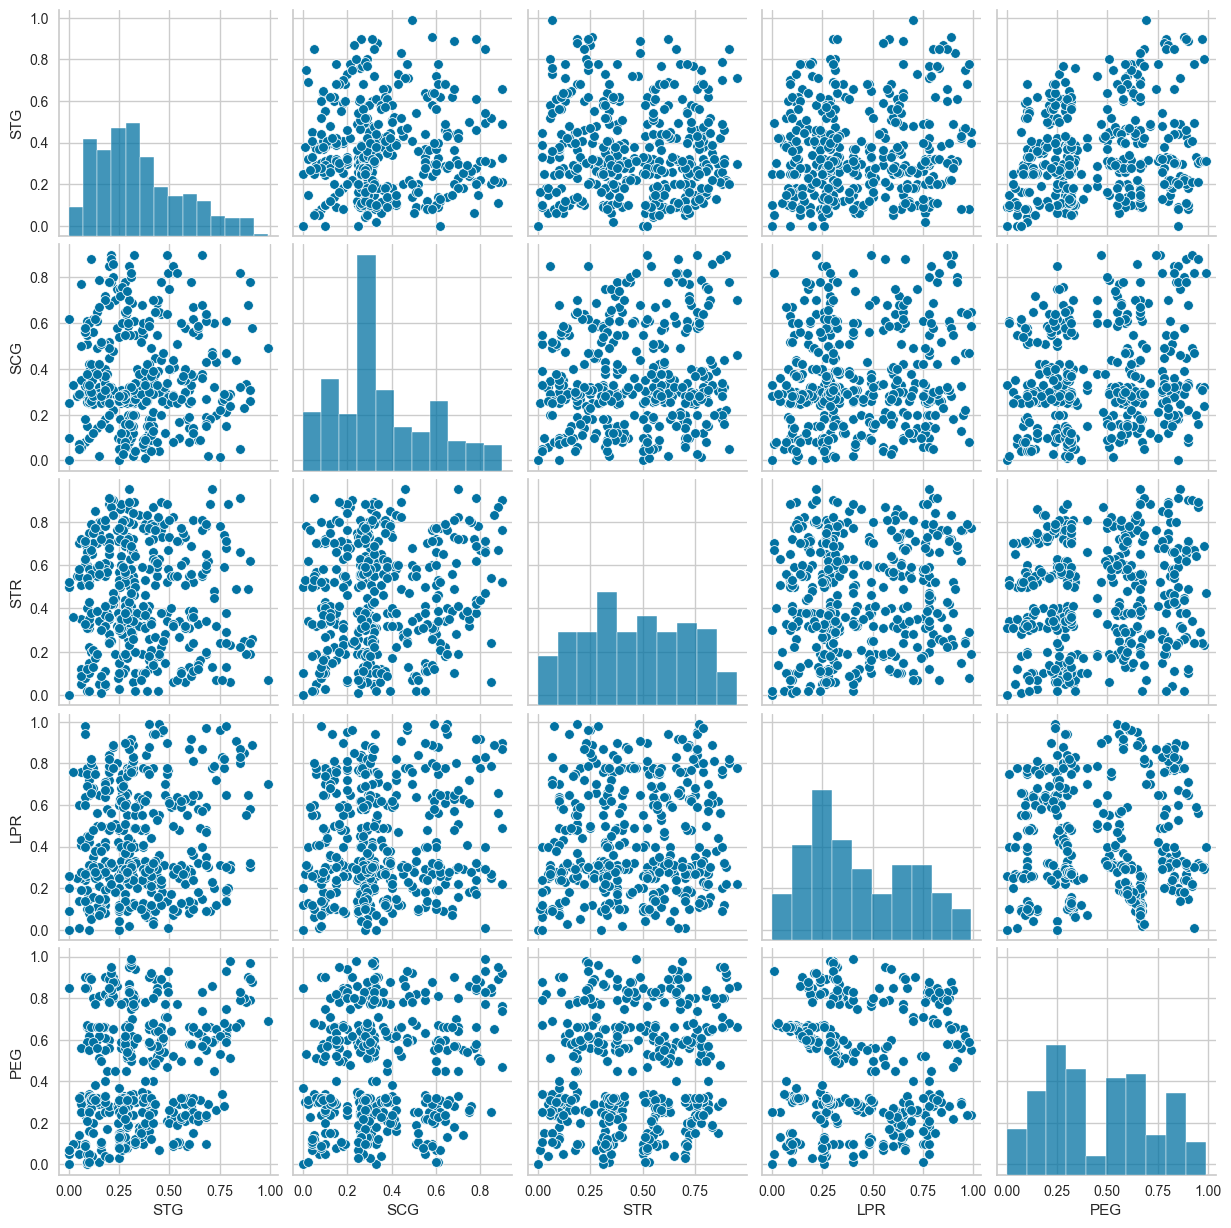

In [162]:
sns.pairplot(X1); 
# datanın uniform dağılım sergilediği, linearity nin olmadığı ve features arası corr çok yüksek olmadığı görülüyor
# görsellerden çokta iyi bir kümeleme elde edemeyeceğimize dair insight elde ediyoruz ama bakıcaz

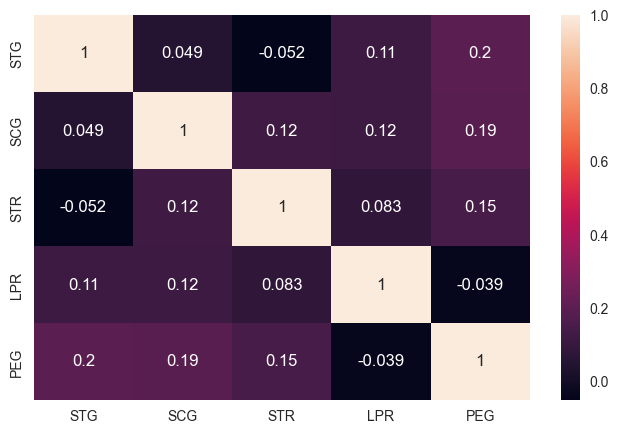

In [163]:
plt.figure(figsize=(8,5))
sns.heatmap(X1.corr(),annot=True)
plt.show() # features arası yüksek corr yok

# K_Means Clustering

In [164]:
def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.
    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """
    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)
    # Sample n observations from D : P
    if sampling_size > data_frame.shape[0]:
        raise Exception(
            'The number of sample of sample is bigger than the shape of D')
    data_frame_sample = data_frame.sample(n=sampling_size)
    # Get the distance to their neirest neighbors in D : X
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
    # Randomly simulate n points with the same variation as in D : Q.
    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()
    uniformly_selected_values_0 = np.random.uniform(min_data_frame[0], max_data_frame[0], sampling_size)
    uniformly_selected_values_1 = np.random.uniform(min_data_frame[1], max_data_frame[1], sampling_size)
    uniformly_selected_observations = np.column_stack((uniformly_selected_values_0, uniformly_selected_values_1))
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(min_data_frame[i], max_data_frame[i], sampling_size)
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)
    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
    # Get the distance to their neirest neighbors in D : Y
    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist
    # return the hopkins score
    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)
    if x + y == 0:
        raise Exception('The denominator of the hopkins statistics is null')
    return x / (x + y)[0]


# normalde bu fonksiyonumuz  pyclustertend'ın hopkins kütüphanesinde var.Ancak oluşabilecek hatalara karşı 
# doğrudan fonksiyonun kendisini kullanacağız . Bundan dolayı pyclustertend'ı install etmemize gerek yoktur! 
                                                #!pip install pyclustertend --user
                                                # from pyclustertend import hopkins

### Hopkins test

In [165]:
hopkins(X1, X1.shape[0]) # clustering için çokta elverişli bir data olmadığı görülüyor, 0 dan uzak 

0.42490983043156344

### Choosing The Optimal Number of Clusters

### inertia

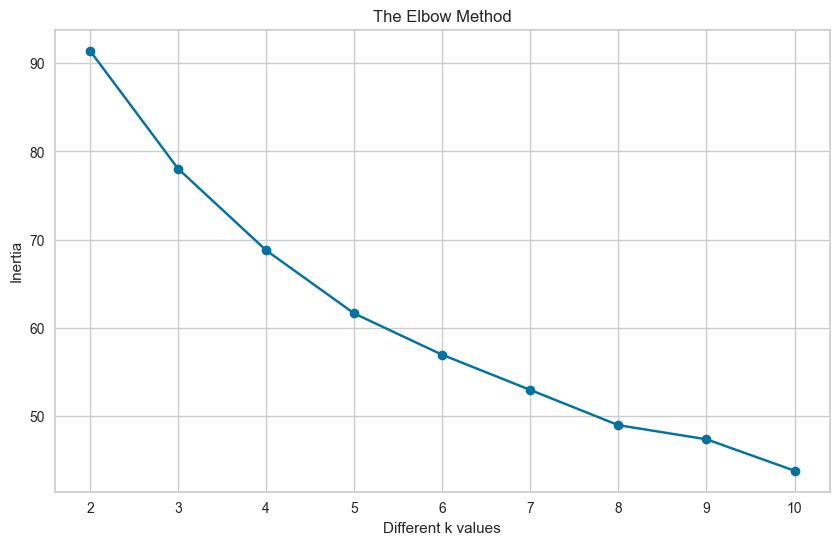

In [166]:
ssd =[]
for n in range(2,11):
    kmeans=KMeans(n_clusters=n,random_state=42)
    kmeans.fit(X1)
    ssd.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), ssd, "bo-")
plt.title('The Elbow Method')
plt.xlabel('Different k values')
plt.ylabel('Inertia')
plt.show()
# keskin düşüşten bahsetmek zor, düşüş devam ediyor

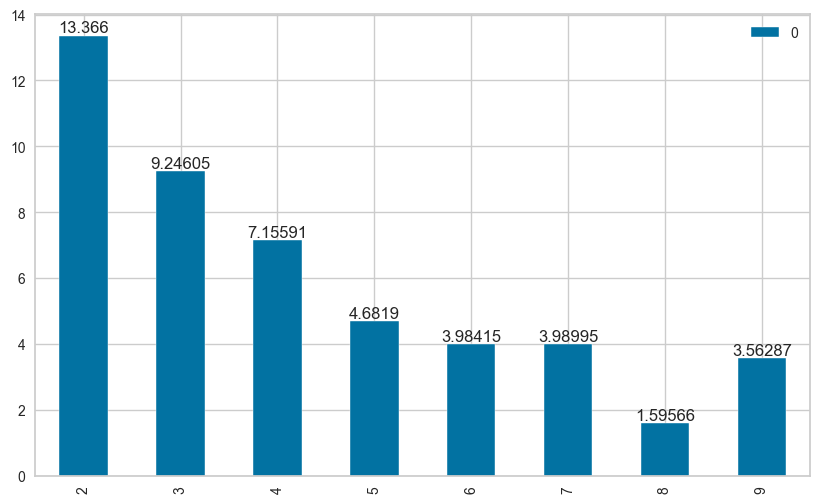

In [167]:
df_diff =pd.DataFrame(-pd.Series(ssd).diff()[1:,]).rename(index = lambda x : x+1)
ax = df_diff.plot(kind='bar', figsize=(10,6))
ax.bar_label(ax.containers[0]);

### distortion

In [168]:
# Distortionda inertia gibi clusterdaki gözlemlerin centroidleri etrafında ne kadar sıkı sıkıya çevrelediğini hesaplar.
# Bu değer ne kadar düşük ise kümeler o kadar centroid etrafında sıkı sıkıya kümelenmiştir anlamına geliyor.

K=range(2,11)
distortion=[]
for k in K:
    kmeanModel = KMeans(n_clusters=k,
                        random_state=42)
    kmeanModel.fit(X1)

    distances = kmeanModel.transform(X1) # her bir gözlemin her bir clusterın centroidine olan mesafeleri
    labels_ = kmeanModel.labels_ # modelin tahmin ettiği clusterlar

    result = []
    for i in range(k):
        cluster_distances = distances[labels_ == i, i] # her bir clusterdaki gözlemlerin kendi centroidlerine olan mesafesi
        result.append(np.mean(cluster_distances**2))# her bir clusterdaki gözlemlerin kendi centroidlerine olan mesafelerinin
                                                      # karelerinin ortalamasını hesaplıyor result listesine atıyoruz.
    distortion.append(sum(result)) #result listesinde bulunan tüm clusterların ortalamalarını toplayıp distortion listesine
                                   #atıyoruz.

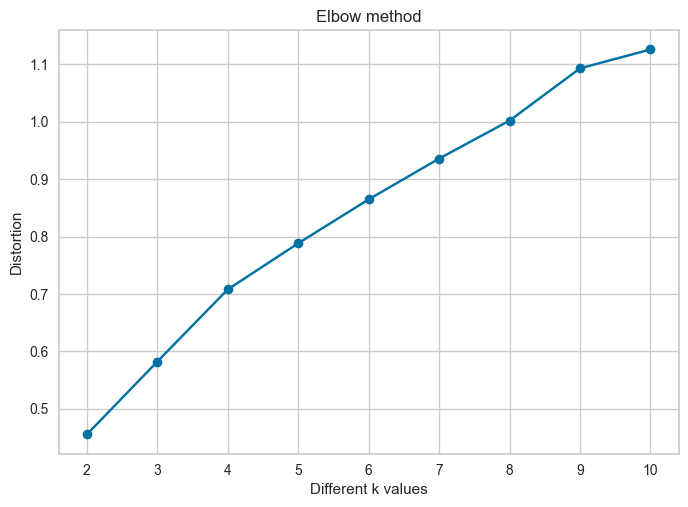

In [169]:
plt.plot(K, distortion, "bo-")
plt.xlabel("Different k values")
plt.ylabel("Distortion") 
plt.title("Elbow method");
# distortion artma eğiliminde yani k büyüdükçe küme içi sıkılık bozuluyor

### silhoutte_score

In [170]:
range_n_clusters = range(2,11)
for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(X1)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")
# inertia ve distortion düşük ve silhouette score un yüksek olduğu bir değere baktığımızda 4,5 ve 6 denenebilir
# inertia, distortion ve silhoette scores beraber değerlendirdiğimizde 4 seçmeye karar verdim

For n_clusters=2, the silhouette score is 0.20615286867087015
For n_clusters=3, the silhouette score is 0.18794077041155124
For n_clusters=4, the silhouette score is 0.19635500816335238
For n_clusters=5, the silhouette score is 0.1918429788849752
For n_clusters=6, the silhouette score is 0.19203185866244862
For n_clusters=7, the silhouette score is 0.18539744241353154
For n_clusters=8, the silhouette score is 0.19108792765706412
For n_clusters=9, the silhouette score is 0.1863761149812597
For n_clusters=10, the silhouette score is 0.19860519387314235


### silhoutte score of each cluster

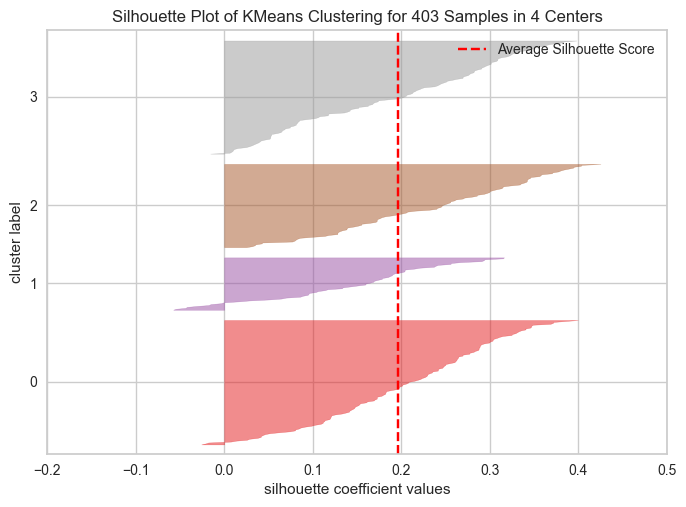

In [171]:
model4 = KMeans(n_clusters=4, random_state=42) 
visualizer = SilhouetteVisualizer(model4)

visualizer.fit(X1)    # Fit the data to the visualizer
visualizer.poof();


In [172]:
for i in range(model4.n_clusters):
    label = (model4.labels_== i)
    print(f"mean silhouette score for label {i:<4} : {visualizer.silhouette_samples_[label].mean()}")
print(f"mean silhouette score for all labels : {visualizer.silhouette_score_}")

mean silhouette score for label 0    : 0.20306611617768336
mean silhouette score for label 1    : 0.13974809471886643
mean silhouette score for label 2    : 0.23421489660217282
mean silhouette score for label 3    : 0.18750185761352875
mean silhouette score for all labels : 0.19635500816335238


In [173]:
clusters = model4.labels_
X1["predicted_clusters"] = clusters
X1

,STG,SCG,STR,LPR,PEG,predicted_clusters
0,0.00,0.00,0.00,0.00,0.00,3
1,0.08,0.08,0.10,0.24,0.90,0
2,0.06,0.06,0.05,0.25,0.33,3
3,0.10,0.10,0.15,0.65,0.30,3
4,0.08,0.08,0.08,0.98,0.24,2
...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,1
399,0.85,0.82,0.66,0.83,0.83,1
400,0.56,0.60,0.77,0.13,0.32,0
401,0.66,0.68,0.81,0.57,0.57,1


In [174]:
clus_pred = X1.groupby("predicted_clusters").mean().T
clus_pred

predicted_clusters,0,1,2,3
STG,0.354075,0.521175,0.288778,0.321090
SCG,0.382515,0.459456,0.361211,0.274500
STR,0.511306,0.512807,0.548556,0.305902
LPR,0.250821,0.767193,0.676444,0.291893
PEG,0.686194,0.727719,0.237222,0.238795


<Axes: >

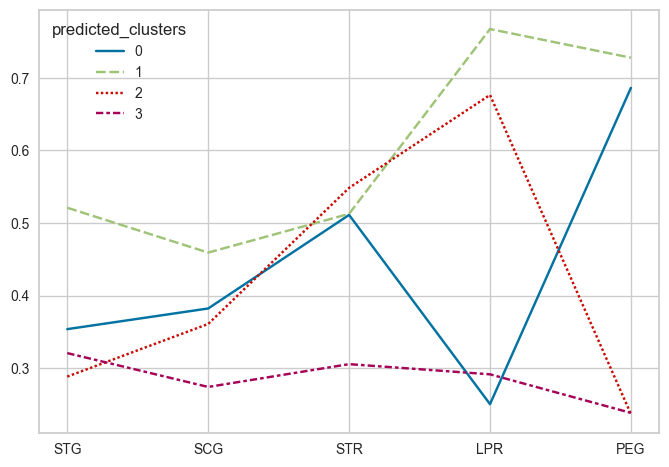

In [175]:
sns.lineplot(data = clus_pred) # STR,LPR,PEG ayırt edici görünüyor

In [176]:
X1["Labels"]=orjinal["UNS"]
X1

,STG,SCG,STR,LPR,PEG,predicted_clusters,Labels
0,0.00,0.00,0.00,0.00,0.00,3,very_low
1,0.08,0.08,0.10,0.24,0.90,0,High
2,0.06,0.06,0.05,0.25,0.33,3,Low
3,0.10,0.10,0.15,0.65,0.30,3,Middle
4,0.08,0.08,0.08,0.98,0.24,2,Low
...,...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,1,High
399,0.85,0.82,0.66,0.83,0.83,1,High
400,0.56,0.60,0.77,0.13,0.32,0,Low
401,0.66,0.68,0.81,0.57,0.57,1,Middle


### Compare results

In [177]:
ct1 = pd.crosstab(X1.predicted_clusters, X1.Labels)
ct1

Labels,High,Low,Middle,very_low
predicted_clusters,,,,
0,50,5,79,0
1,51,0,6,0
2,1,56,27,6
3,0,68,10,44


### Adjust Rand Score

In [178]:
adjusted_rand_score(X1.Labels, X1.predicted_clusters)  

0.30190095294151

# Hierarchical Clustering

In [179]:
X2

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89
399,0.85,0.82,0.66,0.83,0.83
400,0.56,0.60,0.77,0.13,0.32
401,0.66,0.68,0.81,0.57,0.57


In [180]:
hc_ward = linkage(y = X2, method = "ward")                        
hc_complete = linkage(X2, "complete")
hc_average = linkage(X2, "average")
hc_single = linkage(X2, "single")

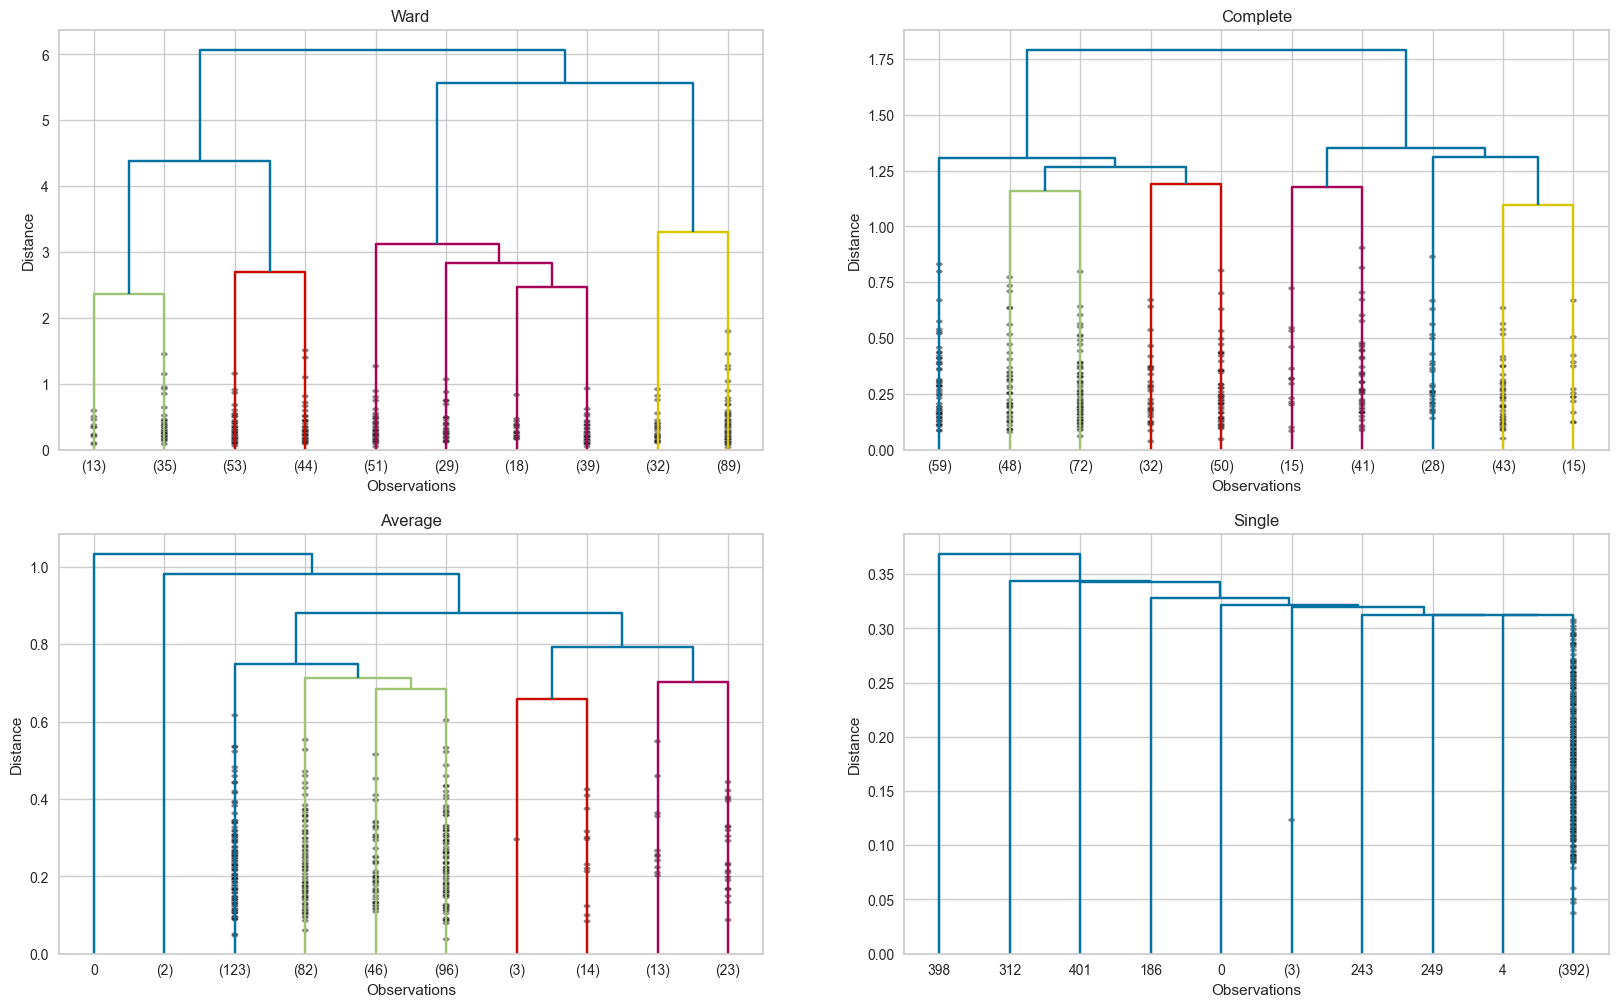

In [181]:
plt.figure(figsize = (20,12))

plt.subplot(221)
plt.title("Ward")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(222)
plt.title("Complete")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_complete, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(223)
plt.title("Average")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_average, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10)

plt.subplot(224)
plt.title("Single")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_single, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10);

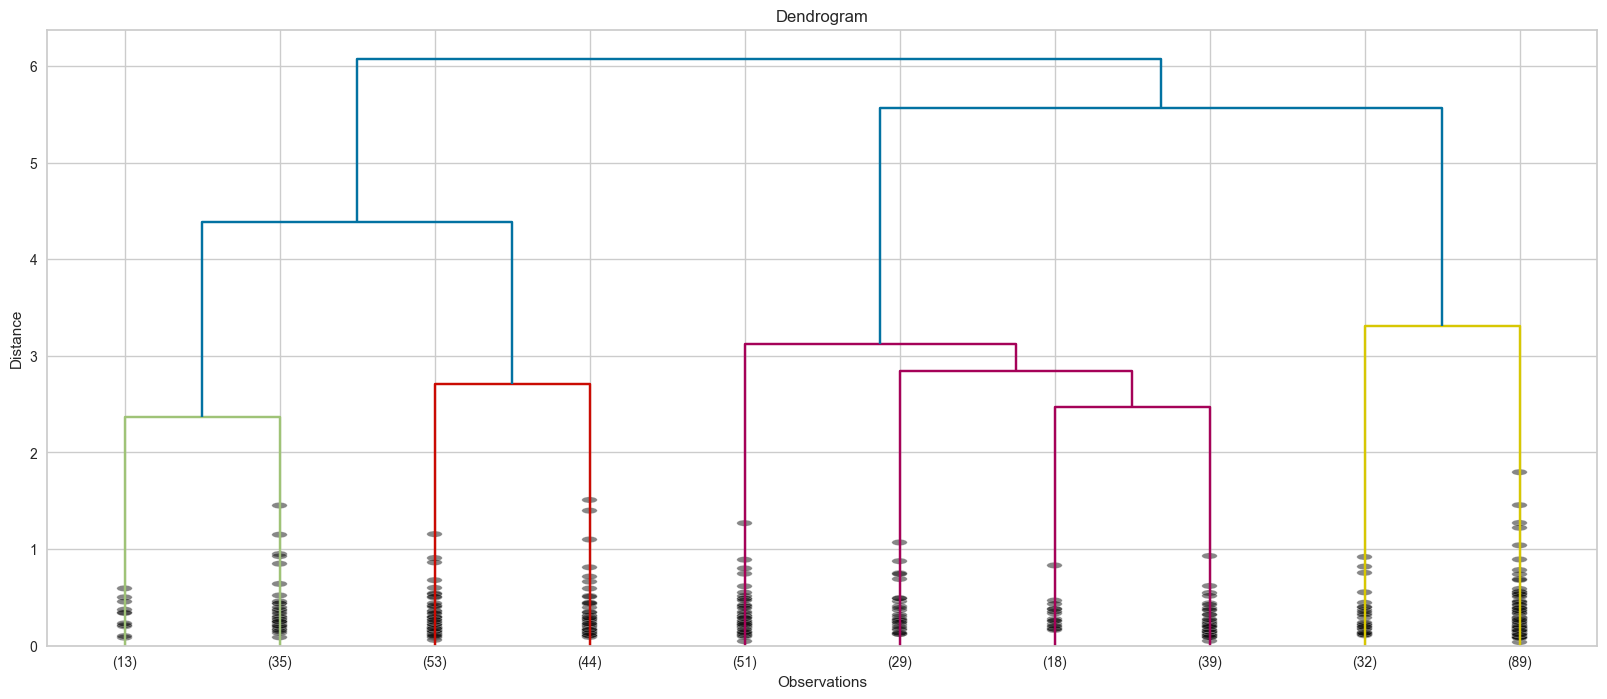

In [182]:
plt.figure(figsize = (20,8))
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10);
# ward 4 tavsiye ediyor

### Silhouette analysis

In [183]:
range_n_clusters = range(2,11)

for num_clusters in range_n_clusters:
    # intialise kmeans
    Agg_model = AgglomerativeClustering(n_clusters=num_clusters)
    Agg_model.fit(X2)
    cluster_labels = Agg_model.labels_
    # silhouette score
    silhouette_avg = silhouette_score(X2, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")
  
# ward 4 , silhouette score da 4 ü tavsiye ediyor o zaman 4 le devam edelim

For n_clusters=2, the silhouette score is 0.16664467420521106
For n_clusters=3, the silhouette score is 0.15807535060316721
For n_clusters=4, the silhouette score is 0.17045086535201248
For n_clusters=5, the silhouette score is 0.1428909404143296
For n_clusters=6, the silhouette score is 0.13676434632522055
For n_clusters=7, the silhouette score is 0.14805282951256238
For n_clusters=8, the silhouette score is 0.15176257691479736
For n_clusters=9, the silhouette score is 0.15179876164405826
For n_clusters=10, the silhouette score is 0.15806145499294894


In [184]:
Agg = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_agg= Agg.fit_predict(X2) 

In [185]:
X2["predicted_clusters"]=y_agg
X2

,STG,SCG,STR,LPR,PEG,predicted_clusters
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,2
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,1
...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,2
399,0.85,0.82,0.66,0.83,0.83,3
400,0.56,0.60,0.77,0.13,0.32,0
401,0.66,0.68,0.81,0.57,0.57,1


In [186]:
clus_pred = X2.groupby("predicted_clusters").mean().T
clus_pred

predicted_clusters,0,1,2,3
STG,0.330471,0.283268,0.372774,0.495458
SCG,0.295554,0.381330,0.351547,0.469396
STR,0.353636,0.520722,0.480839,0.526250
LPR,0.286950,0.661546,0.271752,0.785625
PEG,0.221099,0.273402,0.689416,0.753958


<Axes: >

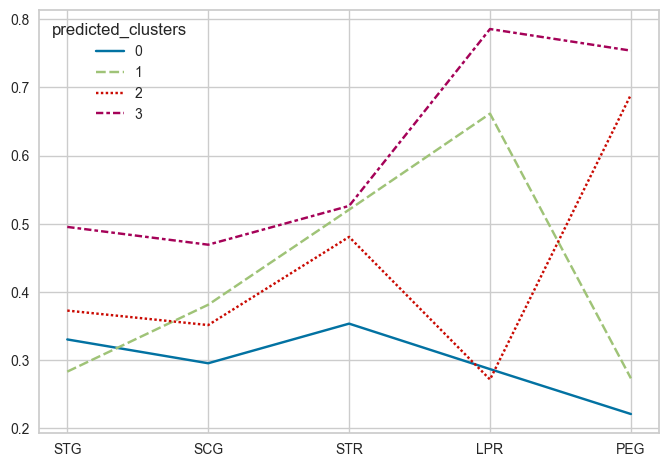

In [187]:
sns.lineplot(data = clus_pred) # LPR,PEG ayırt edici görünüyor

In [188]:
X2["Labels"]=orjinal["UNS"]
X2

,STG,SCG,STR,LPR,PEG,predicted_clusters,Labels
0,0.00,0.00,0.00,0.00,0.00,0,very_low
1,0.08,0.08,0.10,0.24,0.90,2,High
2,0.06,0.06,0.05,0.25,0.33,0,Low
3,0.10,0.10,0.15,0.65,0.30,1,Middle
4,0.08,0.08,0.08,0.98,0.24,1,Low
...,...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,2,High
399,0.85,0.82,0.66,0.83,0.83,3,High
400,0.56,0.60,0.77,0.13,0.32,0,Low
401,0.66,0.68,0.81,0.57,0.57,1,Middle


### Compare results

In [189]:
ct2 = pd.crosstab(X2.predicted_clusters, X2.Labels)
ct2

Labels,High,Low,Middle,very_low
predicted_clusters,,,,
0,0,74,3,44
1,3,53,35,6
2,52,2,83,0
3,47,0,1,0


### Adjust Rand Score

In [190]:
adjusted_rand_score(X2.Labels, X2.predicted_clusters)  

# adjusted_rand_score : 0.30190095294151 with K-Means (4 küme)

# Hierarchical Clustering(4 küme), k-meansten daha başarılı sonuç verdi

0.33367680389900467

# Remodelling with 3 features

In [191]:
X3=orjinal[["STR","PEG","LPR"]] 
X3
# kmeans ve hierchial clustering algoritmaları sonuçlarını beraber değerlendirirsek bu 3 features ayırt edici features olarak görülüyor


,STR,PEG,LPR
0,0.00,0.00,0.00
1,0.10,0.90,0.24
2,0.05,0.33,0.25
3,0.15,0.30,0.65
4,0.08,0.24,0.98
...,...,...,...
398,0.62,0.89,0.32
399,0.66,0.83,0.83
400,0.77,0.32,0.13
401,0.81,0.57,0.57


### Hopkins test

In [192]:
hopkins(X3, X3.shape[0])    # 0.4264139032363097 (Hopkin test for 5 FEATURES ) 
# 5 features a göre 3 features ile kümelemeye daha eğilimli ama yine 0 dan uzak , clustering için çokta elverişli değil

0.37316425799125763

### Silhouette analysis

In [193]:
range_n_clusters = range(2,11)

for num_clusters in range_n_clusters:
    # intialise kmeans
    Agg_model = AgglomerativeClustering(n_clusters=num_clusters)
    Agg_model.fit(X3)
    cluster_labels = Agg_model.labels_
    # silhouette score
    silhouette_avg = silhouette_score(X3, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")
# silhouette scores lar 5 features göre genel olark arttı

For n_clusters=2, the silhouette score is 0.26372353704232593
For n_clusters=3, the silhouette score is 0.2801779026137965
For n_clusters=4, the silhouette score is 0.3024823239186014
For n_clusters=5, the silhouette score is 0.28564217903333083
For n_clusters=6, the silhouette score is 0.2967023888290615
For n_clusters=7, the silhouette score is 0.3050321372218504
For n_clusters=8, the silhouette score is 0.325717229336517
For n_clusters=9, the silhouette score is 0.31161039209483893
For n_clusters=10, the silhouette score is 0.2981176368084819


In [194]:
Agg2 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_agg2= Agg2.fit_predict(X3)

In [195]:
X3["predicted_clusters"]=y_agg2
X3

,STR,PEG,LPR,predicted_clusters
0,0.00,0.00,0.00,0
1,0.10,0.90,0.24,2
2,0.05,0.33,0.25,0
3,0.15,0.30,0.65,1
4,0.08,0.24,0.98,1
...,...,...,...,...
398,0.62,0.89,0.32,2
399,0.66,0.83,0.83,3
400,0.77,0.32,0.13,0
401,0.81,0.57,0.57,1


In [196]:
X3["Labels"]=orjinal["UNS"]
X3

,STR,PEG,LPR,predicted_clusters,Labels
0,0.00,0.00,0.00,0,very_low
1,0.10,0.90,0.24,2,High
2,0.05,0.33,0.25,0,Low
3,0.15,0.30,0.65,1,Middle
4,0.08,0.24,0.98,1,Low
...,...,...,...,...,...
398,0.62,0.89,0.32,2,High
399,0.66,0.83,0.83,3,High
400,0.77,0.32,0.13,0,Low
401,0.81,0.57,0.57,1,Middle


### Compare results

In [197]:
ct3 = pd.crosstab(X3.predicted_clusters, X3.Labels)
ct3

Labels,High,Low,Middle,very_low
predicted_clusters,,,,
0,0,72,0,45
1,1,57,29,5
2,51,0,81,0
3,50,0,12,0


### Adjust Rand Score

In [198]:
adjusted_rand_score(X3.Labels, X3.predicted_clusters)  # 0.33367680389900467 (Hierarchical for 5 features)
# 3 features ile Hierarchical da 5 features göre kısmen daha iyi sonuç aldık

0.3467503374610816

In [199]:
# en iyi kümelemeyi bu 3 features ve hierarchical clstering(4 kümeleme) ile aldık bunu görselleştirelim.
fig = px.scatter_3d(X3, 
                    x='STR',
                    y='PEG',
                    z='LPR',
                    color='predicted_clusters')
fig.show();

# Hierarchical Clustering with PCA

In [200]:
X4=orjinal.drop(columns= "UNS")
X4

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24
...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89
399,0.85,0.82,0.66,0.83,0.83
400,0.56,0.60,0.77,0.13,0.32
401,0.66,0.68,0.81,0.57,0.57


In [201]:
scaler = StandardScaler() 
scaled_X = scaler.fit_transform(X4)

Text(0, 0.5, 'Variance Ratio')

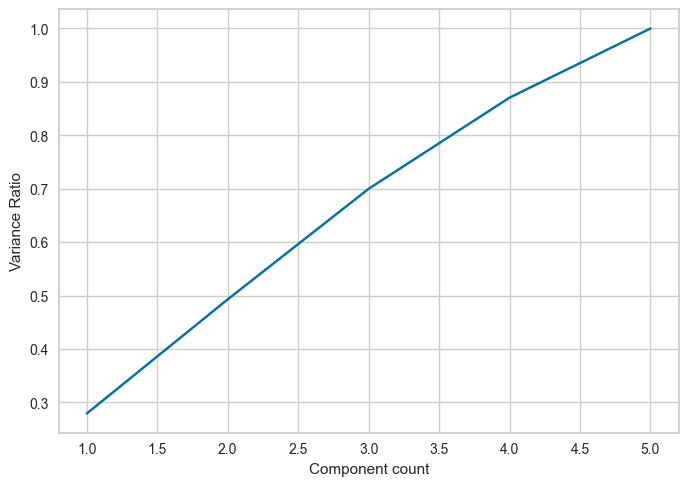

In [202]:
x = range(1,6)
pca = PCA().fit(scaled_X)
plt.plot(x, pca.explained_variance_ratio_.cumsum())

plt.xlabel("Component count")
plt.ylabel("Variance Ratio")


In [203]:
pca = PCA(n_components=3) # 3 component datanın %70 ini ifade ettiği için 3 ü seçtim, 4 componente sonuçlar çok farklı çıkmıyor

In [204]:
principal_components = pca.fit_transform(scaled_X)

In [205]:
hopkins(principal_components, principal_components.shape[0]) 
# 3 component ile hopkins score çokta değişmedi 5 ya da 3 features a göre, hala 0 dan uzak ve clustering için elverişli değil

0.3150522092050097

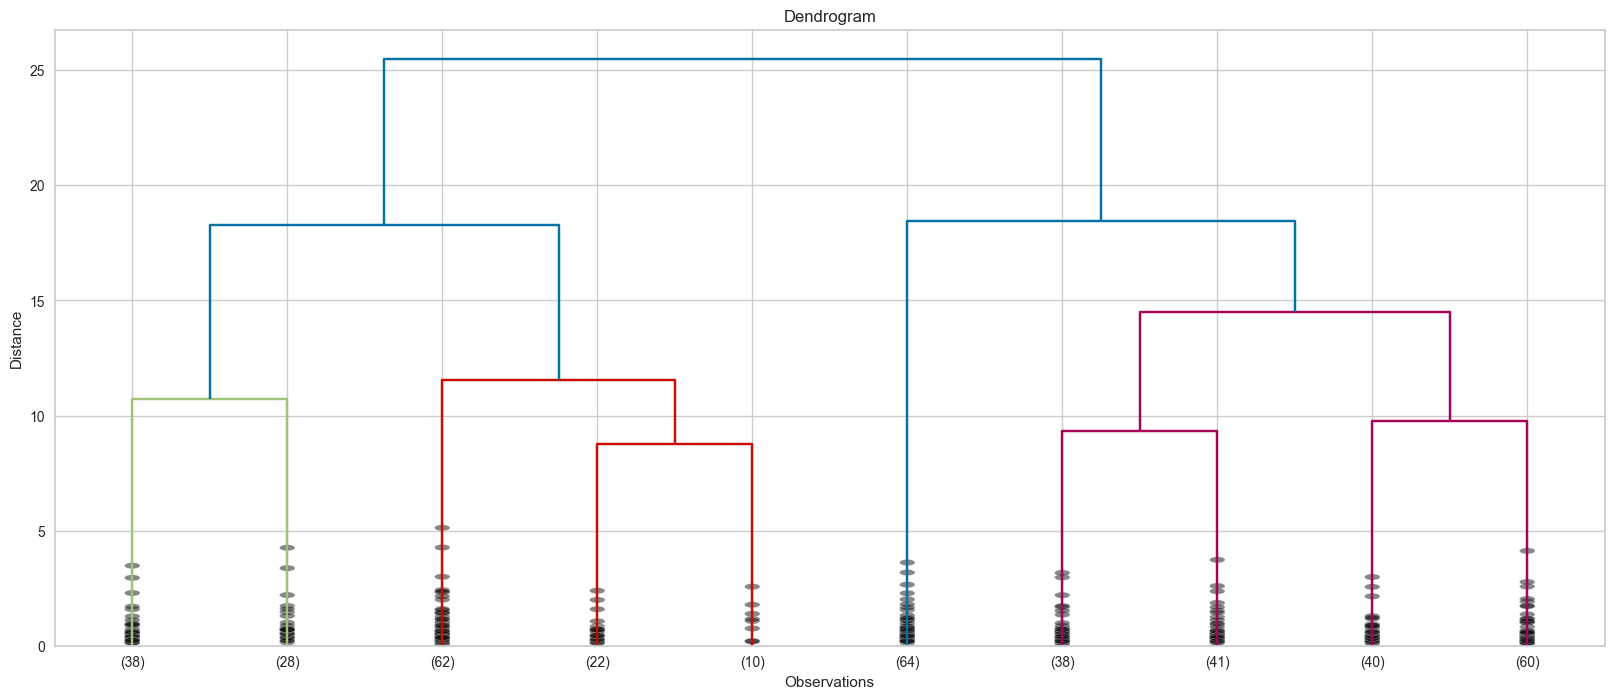

In [206]:
hc_ward = linkage(y = principal_components, method = "ward") 
plt.figure(figsize = (20,8))
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hc_ward, truncate_mode = "lastp", p = 10, show_contracted = True, leaf_font_size = 10);   

In [207]:
range_n_clusters = range(2,11)

for num_clusters in range_n_clusters:
    # intialise kmeans
    Agg_model = AgglomerativeClustering(n_clusters=num_clusters)
    Agg_model.fit(principal_components)
    cluster_labels = Agg_model.labels_
    # silhouette score
    silhouette_avg = silhouette_score(principal_components, cluster_labels)
    print(f"For n_clusters={num_clusters}, the silhouette score is {silhouette_avg}")
# ward ve silhouette score a göre 4 kümelemeyi seçtim

For n_clusters=2, the silhouette score is 0.22566878251234848
For n_clusters=3, the silhouette score is 0.18529405039975716
For n_clusters=4, the silhouette score is 0.21270423941245106
For n_clusters=5, the silhouette score is 0.20504145145670383
For n_clusters=6, the silhouette score is 0.22082888133426418
For n_clusters=7, the silhouette score is 0.21681459857542046
For n_clusters=8, the silhouette score is 0.21265543345833113
For n_clusters=9, the silhouette score is 0.21610495346229236
For n_clusters=10, the silhouette score is 0.22473416805561952


In [208]:
Agg3 = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
y_agg3= Agg3.fit_predict(principal_components)

In [209]:
X4["predicted_clusters"]=y_agg3
X4

,STG,SCG,STR,LPR,PEG,predicted_clusters
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,0
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,2
4,0.08,0.08,0.08,0.98,0.24,2
...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,1
399,0.85,0.82,0.66,0.83,0.83,1
400,0.56,0.60,0.77,0.13,0.32,3
401,0.66,0.68,0.81,0.57,0.57,3


In [210]:
X4["Labels"]=orjinal["UNS"]
X4

,STG,SCG,STR,LPR,PEG,predicted_clusters,Labels
0,0.00,0.00,0.00,0.00,0.00,0,very_low
1,0.08,0.08,0.10,0.24,0.90,0,High
2,0.06,0.06,0.05,0.25,0.33,0,Low
3,0.10,0.10,0.15,0.65,0.30,2,Middle
4,0.08,0.08,0.08,0.98,0.24,2,Low
...,...,...,...,...,...,...,...
398,0.90,0.78,0.62,0.32,0.89,1,High
399,0.85,0.82,0.66,0.83,0.83,1,High
400,0.56,0.60,0.77,0.13,0.32,3,Low
401,0.66,0.68,0.81,0.57,0.57,3,Middle


In [211]:
adjusted_rand_score(X4.Labels, X4.predicted_clusters) # 3 componentle iyi bir sonuç elde edemedik

0.0734807049118908

# Conclusion

In [212]:
# Data üzerinde K-means ve Hierarchical denedik, bu data için  Hierarchical clustering algoritmasının daha başarılı olduğu gördük.
# Data kompleks bir data değil dimension reduction a ihtiyaç duymuyor normalde ama PCA denedik, 
# Ayrıca lineara uygun bir data değil ve features arası yüksek corr yok. Zaten bu şartlarda PCA iyi bir sonuç vermezdi.
# Sonuçlardan da PCA işe yarar bir boyut indirgeme yapmadığını gördük.